# Synthetic Data generation using Variational Autoencoders.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import layers, models, losses
from tensorflow.keras.optimizers import Adam
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Setting up the eager mode in tensorflow
tf.config.run_functions_eagerly(True)

Loading the Data : card_transaction.v1.csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/Fraud Analytics Datasets/SDG_VAE

file_name = 'card_transaction.v1.csv'
data = pd.read_csv(file_name)

print("First 10 row of data set")
print(data.head(11))

/content/drive/My Drive/Fraud Analytics Datasets/SDG_VAE
First 10 row of data set
    User  Card  Year  Month  Day   Time   Amount           Use Chip  \
0      0     0  2002      9    1  06:21  $134.09  Swipe Transaction   
1      0     0  2002      9    1  06:42   $38.48  Swipe Transaction   
2      0     0  2002      9    2  06:22  $120.34  Swipe Transaction   
3      0     0  2002      9    2  17:45  $128.95  Swipe Transaction   
4      0     0  2002      9    3  06:23  $104.71  Swipe Transaction   
5      0     0  2002      9    3  13:53   $86.19  Swipe Transaction   
6      0     0  2002      9    4  05:51   $93.84  Swipe Transaction   
7      0     0  2002      9    4  06:09  $123.50  Swipe Transaction   
8      0     0  2002      9    5  06:14   $61.72  Swipe Transaction   
9      0     0  2002      9    5  09:35   $57.10  Swipe Transaction   
10     0     0  2002      9    5  20:18   $76.07  Swipe Transaction   

    Merchant Name  Merchant City Merchant State      Zip     MCC 

Removing dollar and Printing the target values

In [5]:
data['Amount'] = data['Amount'].replace('[\$]','', regex=True).astype(float)
print(data['Amount'].head(11))

0     134.09
1      38.48
2     120.34
3     128.95
4     104.71
5      86.19
6      93.84
7     123.50
8      61.72
9      57.10
10     76.07
Name: Amount, dtype: float64


Encoding the columns into numerical values and printing them

In [6]:
columnLabelEncoders = {}
# columnsToRemove = {'Amount','User','Card','Year','Month','Day','Merchant Name','Zip','MCC'}
columnsToRemove = {'Amount'}
for column in data.select_dtypes(include='object').columns:
    if column not in columnsToRemove:
      columnLabelEncoders[column] = LabelEncoder()
      data[column] = columnLabelEncoders[column].fit_transform(data[column])

# Printing the features after encoding them into numerical values.
print(data.head(10))

   User  Card  Year  Month  Day  Time  Amount  Use Chip  Merchant Name  \
0     0     0  2002      9    1   381  134.09         2   3.527213e+18   
1     0     0  2002      9    1   402   38.48         2  -7.276121e+17   
2     0     0  2002      9    2   382  120.34         2  -7.276121e+17   
3     0     0  2002      9    2  1066  128.95         2   3.414527e+18   
4     0     0  2002      9    3   383  104.71         2   5.817218e+18   
5     0     0  2002      9    3   834   86.19         2  -7.146671e+18   
6     0     0  2002      9    4   351   93.84         2  -7.276121e+17   
7     0     0  2002      9    4   369  123.50         2  -7.276121e+17   
8     0     0  2002      9    5   374   61.72         2  -7.276121e+17   
9     0     0  2002      9    5   575   57.10         2   4.055257e+18   

   Merchant City  Merchant State      Zip     MCC  Errors?  Is Fraud?  
0           3696              16  91750.0  5300.0       20          0  
1           4600              16  91754.0

Now Replacing Nan and Inf value with mean of the data

In [7]:
data = data.fillna(data.mean())

Doing Train Test Split(TTS)

In [8]:

# trainData,testData = train_test_split(data,test_size=0.2,random_state=48)

Now scaling the data between 0 and 1.

In [9]:
scaler = MinMaxScaler()
num_cols = data.select_dtypes(include=['float64','int64']).columns
# data[num_cols] = scaler.fit_transform(data[num_cols])
# train_num_cols = trainData[num_cols]
# test_num_cols = testData[num_cols]
data_num_cols = data[num_cols]

scaler.fit(data_num_cols)
# trainData[num_cols] = scaler.transform(train_num_cols)
# testData[num_cols] = scaler.transform(test_num_cols)
data[num_cols] = scaler.transform(data)

# Printing features after scaling
print("Data After scaling")
print(data.head(11))

Data After scaling
    User  Card  Year     Month       Day      Time    Amount  Use Chip  \
0    0.0   0.0  0.28  0.727273  0.000000  0.264583  0.086622  0.666667   
1    0.0   0.0  0.28  0.727273  0.000000  0.279167  0.073561  0.666667   
2    0.0   0.0  0.28  0.727273  0.033333  0.265278  0.084744  0.666667   
3    0.0   0.0  0.28  0.727273  0.033333  0.740278  0.085920  0.666667   
4    0.0   0.0  0.28  0.727273  0.066667  0.265972  0.082608  0.666667   
5    0.0   0.0  0.28  0.727273  0.066667  0.579167  0.080078  0.666667   
6    0.0   0.0  0.28  0.727273  0.100000  0.243750  0.081123  0.666667   
7    0.0   0.0  0.28  0.727273  0.100000  0.256250  0.085175  0.666667   
8    0.0   0.0  0.28  0.727273  0.133333  0.259722  0.076736  0.666667   
9    0.0   0.0  0.28  0.727273  0.133333  0.399306  0.076104  0.666667   
10   0.0   0.0  0.28  0.727273  0.133333  0.846528  0.078696  0.666667   

    Merchant Name  Merchant City  Merchant State       Zip       MCC  Errors?  \
0        0.

Now checking whether any null or infinite values are present or not

In [10]:
if data.isnull().values.any() or np.isinf(data.values).any():
    raise ValueError("Data contains NaN or infinite values")

Defining the variational autoencoder class

In [11]:
class VariationalAutoEncoder(models.Model):
    def __init__(this,originalDimension,latentDimension):
        super(VariationalAutoEncoder,this).__init__()

        this.latentDimension = latentDimension

        # Defining the encoder
        this.encoder = models.Sequential([
            layers.Dense(originalDimension, activation='relu'),
            layers.Dense(12, activation='relu'),
            layers.Dense(10, activation='relu'),
            layers.Dense(2 * latentDimension)
        ])

        # Defining the decoder
        this.decoder = models.Sequential([
            layers.Dense(2 * latentDimension),
            layers.Dense(10, activation='relu'),
            layers.Dense(12, activation='relu'),
            layers.Dense(originalDimension,activation='sigmoid')
        ])

    # Function for encoding data
    def encodeData(this,x):
        meanLogVariance = this.encoder(x)
        mean = meanLogVariance[:, :this.latentDimension]
        logVariance = meanLogVariance[:, this.latentDimension:]
        eps = tf.random.normal(shape=(mean.shape[0], this.latentDimension))
        standardDeviation = tf.exp(0.5 * logVariance)
        z = mean + eps * standardDeviation
        return this.decoder(z)

    # Function for reparameterize data
    def reparameterization(this, mean, logVariance):
        eps = tf.random.normal(shape=(mean.shape[0], this.latentDimension))
        standardDeviation = tf.exp(0.5 * logVariance)
        z = mean + eps * standardDeviation

        return z

    # Abstract function for encoding the data
    def decodeData(this,z):
        return this.decoder(z)

    # kind of Main function
    def call(this, inputs):
        reconstruct = this.encodeData(inputs)
        # z = this.reparameterization(mean, logVariance)
        # reconstruct = this.decoder(z)

        return reconstruct




Defining the Loss calulaing function for retraining

In [12]:
# Function for calculating the loss, it is used during back propagation
# For re-adjusting the parameters
def LossCalculatorVAE(originalData, reconstruction, mean, logVariance):
    reconstructionLoss = losses.binary_crossentropy(originalData, reconstruction)
    reconstructionLoss = tf.reduce_mean(reconstructionLoss)

    KL_divergence = -0.5 * tf.reduce_mean(1 + logVariance - tf.square(mean) - tf.exp(logVariance))

    return reconstructionLoss + KL_divergence

Activating GPU

In [13]:
print("GPU available:", tf.test.is_gpu_available())
print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU available: False
TensorFlow is using GPU: True


Now code for compiling the model

In [14]:
originalDimension = data.shape[1]
latentDimension = 4
optimizer = Adam(learning_rate=0.001)
VAE_model = VariationalAutoEncoder(originalDimension=originalDimension,latentDimension=latentDimension)

# VAE_model.compile(optimizer=optimizer,loss=LossCalculatorVAE)

**Now Training the VAE model**

In [16]:
# Train the VAE model
VAE_model.compile(optimizer='adam',loss='mse')
# data_dataset = data_dataset.batch(64)
VAE_model.fit(data, data,epochs=15, batch_size=500)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5111/5111 [==============================] - 296s 58ms/step - loss: 0.0348
Epoch 2/15
5111/5111 [==============================] - 293s 57ms/step - loss: 0.0227
Epoch 3/15
5111/5111 [==============================] - 289s 56ms/step - loss: 0.0215
Epoch 4/15
5111/5111 [==============================] - 291s 57ms/step - loss: 0.0210
Epoch 5/15
5111/5111 [==============================] - 292s 57ms/step - loss: 0.0207
Epoch 6/15
5111/5111 [==============================] - 319s 62ms/step - loss: 0.0205
Epoch 7/15
5111/5111 [==============================] - 288s 56ms/step - loss: 0.0204
Epoch 8/15
5111/5111 [==============================] - 295s 58ms/step - loss: 0.0204
Epoch 9/15
5111/5111 [==============================] - 301s 59ms/step - loss: 0.0203
Epoch 10/15
5111/5111 [==============================] - 291s 57ms/step - loss: 0.0203
Epoch 11/15
5111/5111 [==============================] - 288s 56ms/step - loss: 0.0203
Epoch 12/15
5111/5111 [==============================] - 296s 5

Function for Decoding the Data

Now saving the model

In [23]:
from tensorflow.keras.models import save_model, Sequential

# Assuming 'VAE_model' is your Keras model object

# Save the weights of the model
VAE_model.save_weights("SDG_VAE_MODEL_weights.h5")


Now generating Synthetic data

In [24]:
num_samples = 2000000

# Sample latent vectors from a Gaussian distribution
latent_dim = 4  # Assuming the latent dimension of your VAE model
latent_samples = np.random.normal(size=(num_samples, latent_dim))

# Use the decoder part of the VAE model to generate synthetic data
synthetic_data = VAE_model.decoder.predict(latent_samples)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


62500/62500 [==============================] - 277s 4ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'head'

Now Calculating Metrics

In [ ]:
# Importing library
from scipy.stats import ks_2samp

def calculateMetrics(realData,syntheticData):
  pass

Plotting Distribution

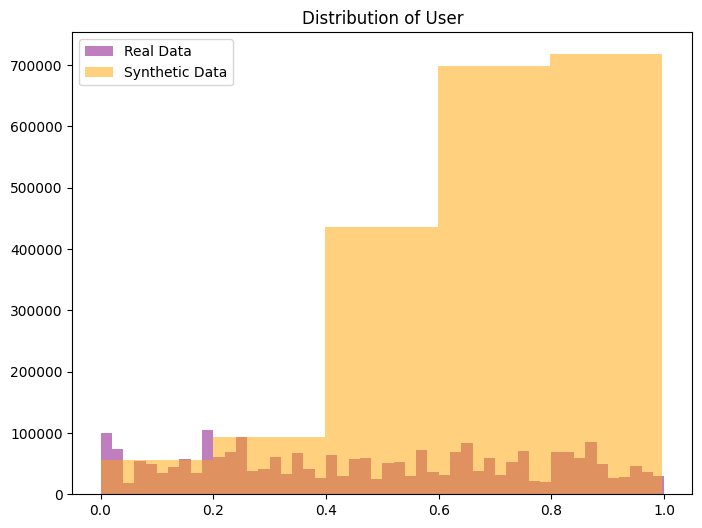

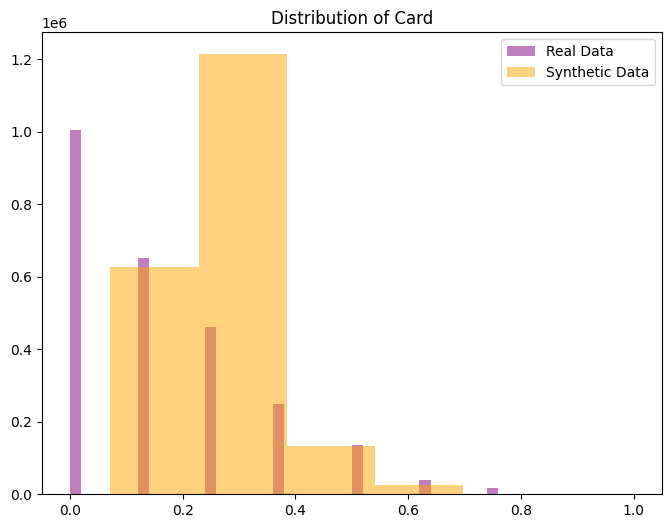

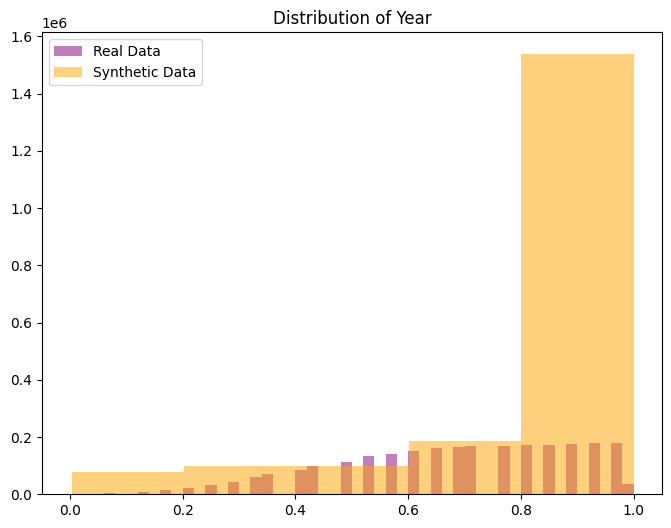

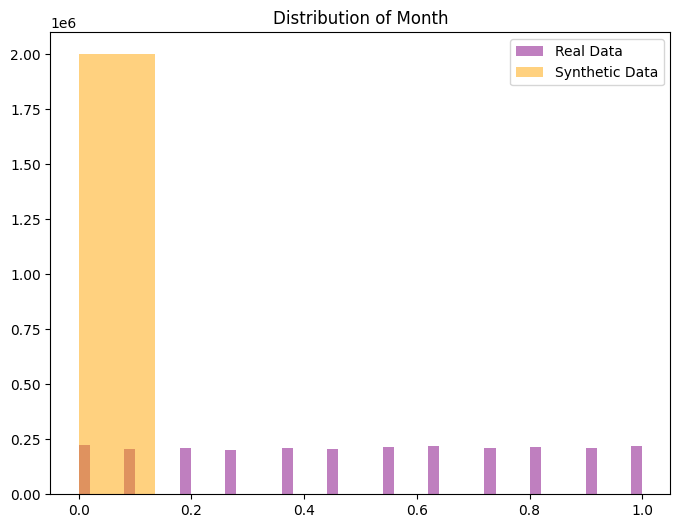

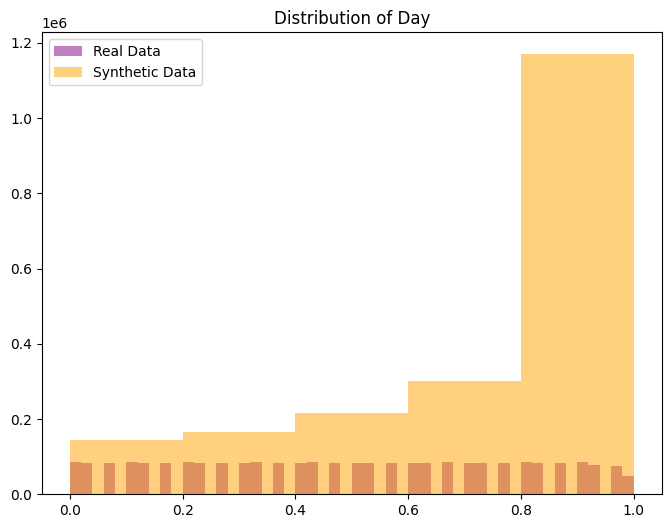

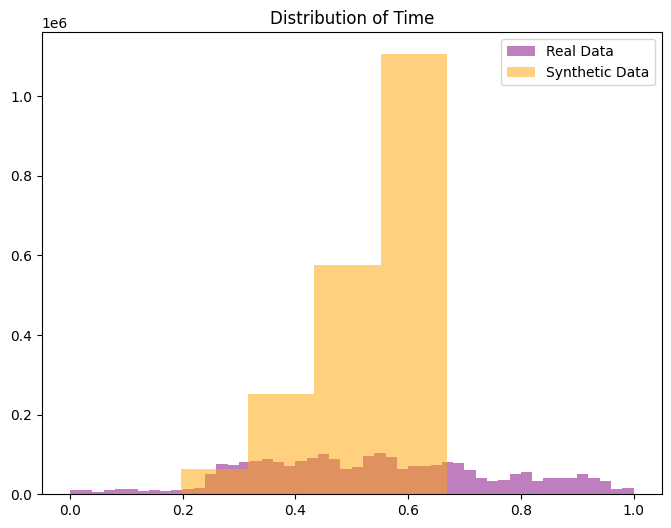

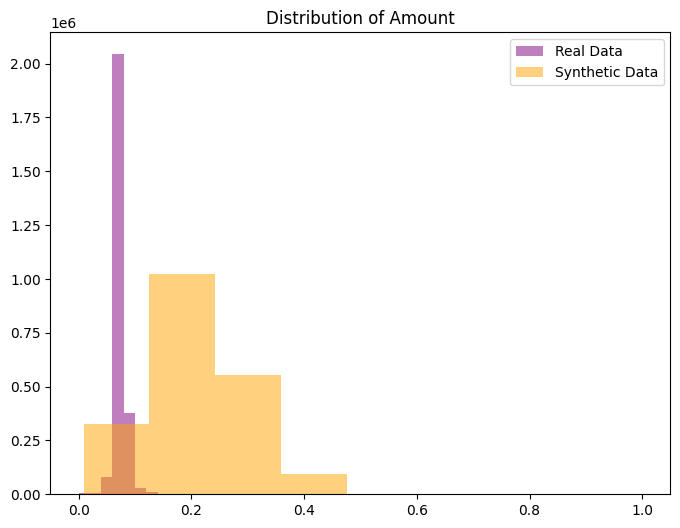

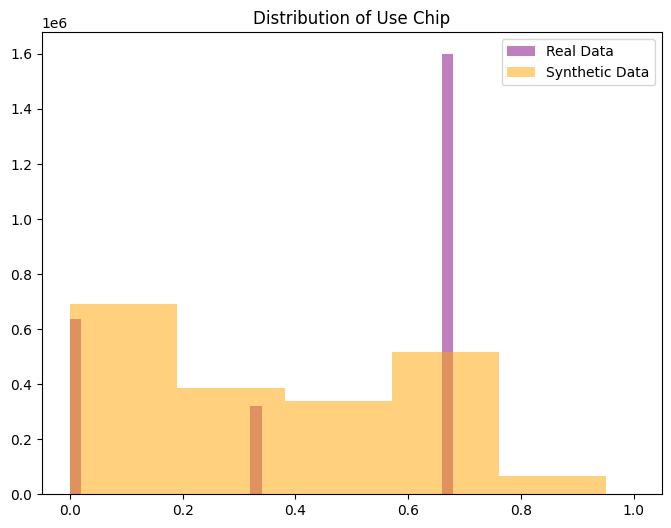

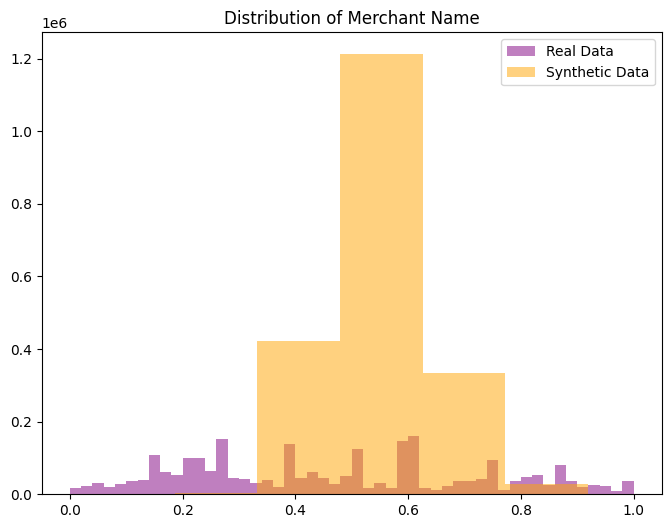

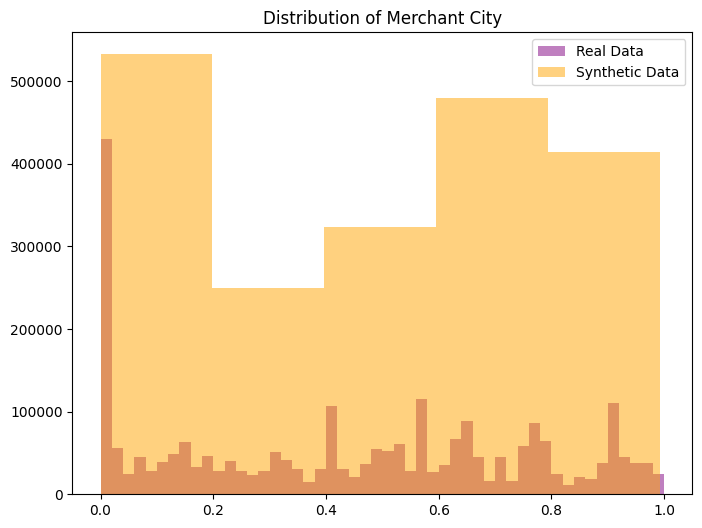

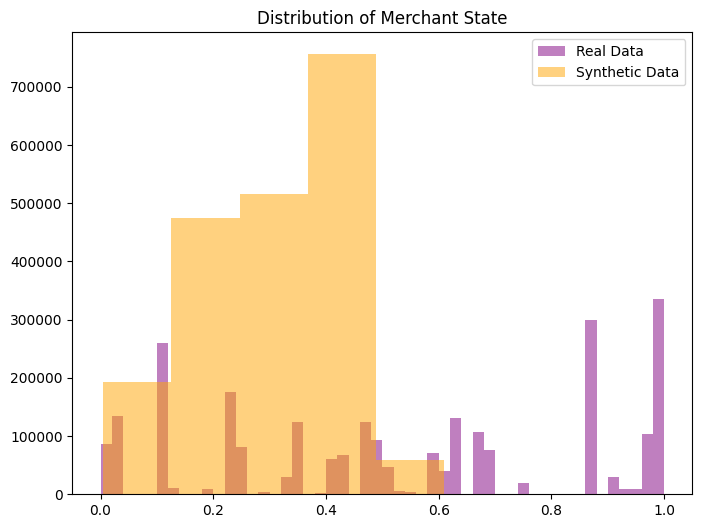

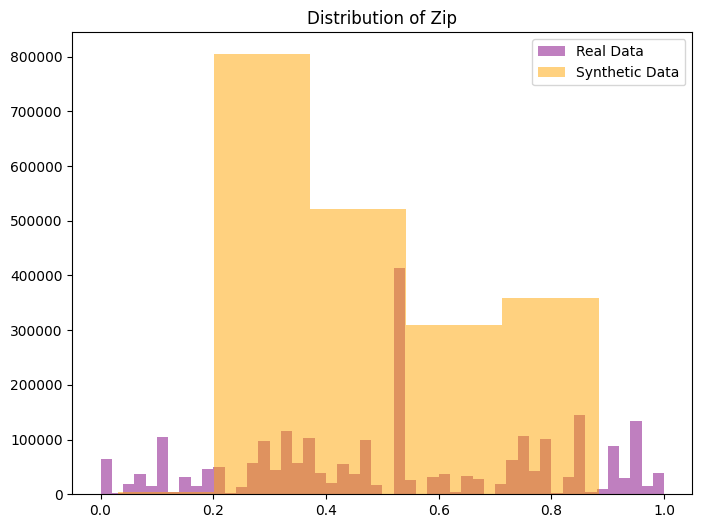

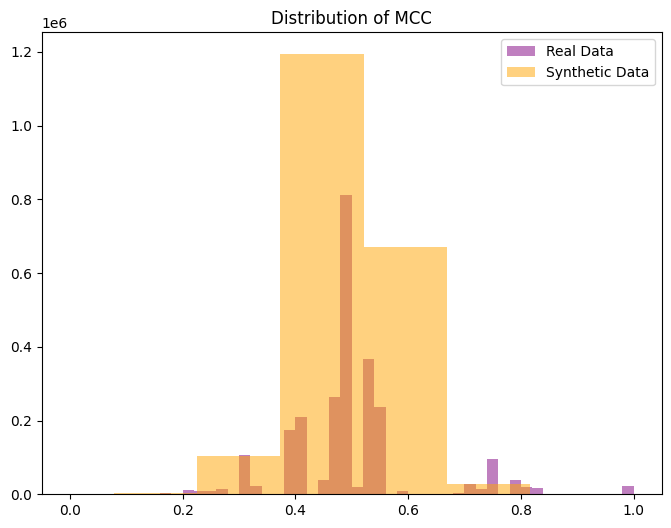

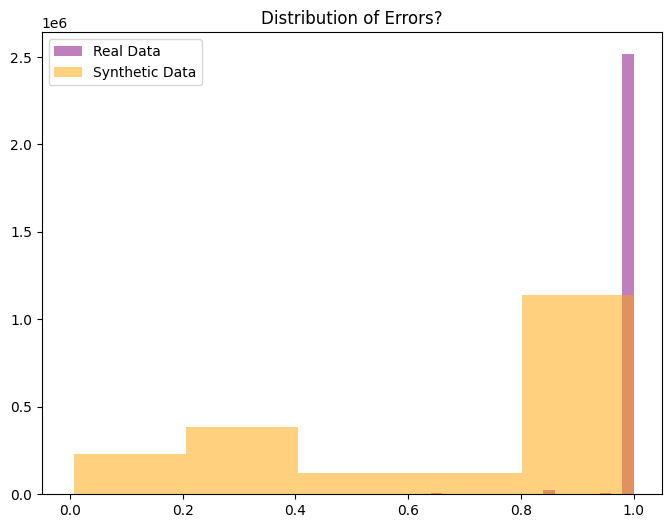

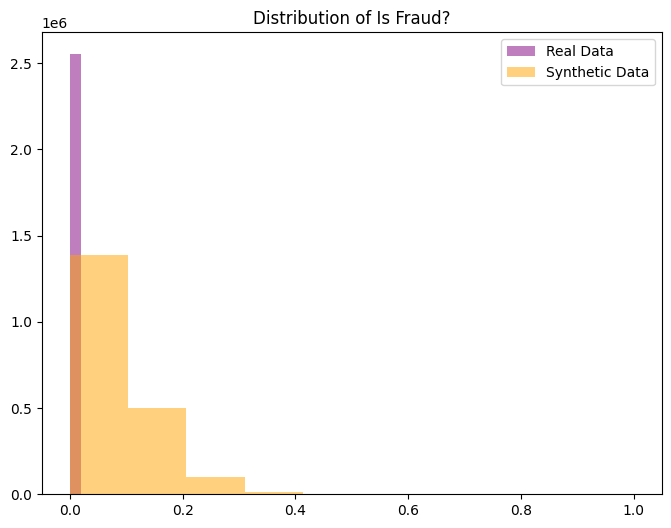

In [43]:
name = "plot_"
for col in data.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(data[col], bins=50, alpha=0.5, color='purple', label='Real Data')
    plt.hist(synthetic_data[:, data.columns.get_loc(col)], bins=5, alpha=0.5, color='orange', label='Synthetic Data')
    plt.title(f'Distribution of {col}')
    plt.legend()
    saveName = name + str(col)
    plt.savefig(saveName)
    plt.show()


Calculating the metrices

In [33]:
print(type(synthetic_data))
from scipy.stats import ks_2samp, entropy

metrics = {}
for i, col in enumerate(data.columns):
  # Calculate KS statistic
  ks_statistic, ks_p_value = ks_2samp(data[col], synthetic_data[:, i])
  metrics[f"{col}_ks_statistic"] = ks_statistic
  metrics[f"{col}_ks_p_value"] = ks_p_value

# Calculate KL divergence
num_samples_to_compare = min(len(data), len(synthetic_data))
for i, col in enumerate(data.columns):
  # Calculate KL divergence
  kl_divergence = entropy(data[col][:num_samples_to_compare], synthetic_data[:num_samples_to_compare, i])
  metrics[f"{col}_kl_divergence"] = kl_divergence

<class 'numpy.ndarray'>


Plotting metrices

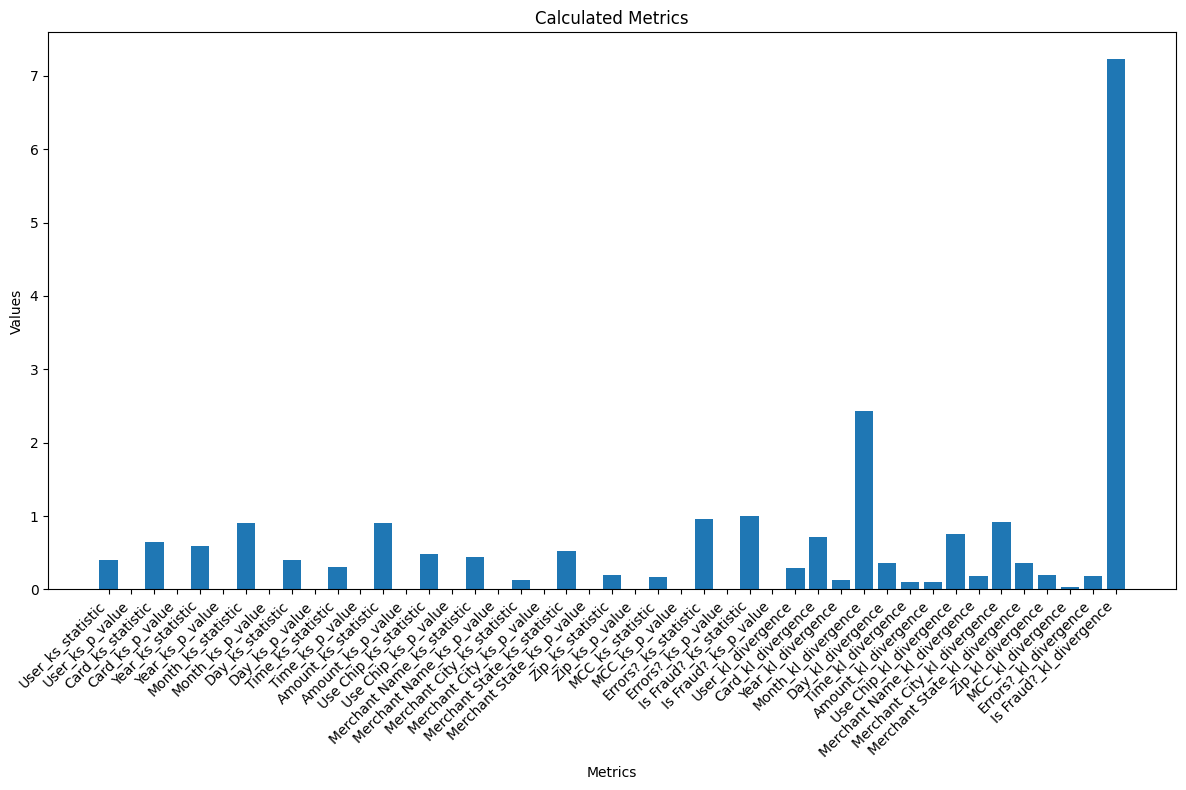

In [37]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Create a bar plot
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
plt.bar(metric_names, metric_values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Calculated Metrics')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels and adjust font size
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('metrics.png')
plt.show()